In [1]:
! pip install diffprivlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 24.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 3.7 MB/s eta 0:00:00


In [15]:
import diffprivlib.models as ibm
from diffprivlib.models import LogisticRegression as dp_LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Import data from github

In [16]:
df_unprocessed = pd.read_csv("https://raw.githubusercontent.com/oliver-miller/ECSE557/master/A2/heart_assignment2.csv")
display(df_unprocessed)

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,Asian,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,Other,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,Other,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,White,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,Other,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,Black,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,Hispanic,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,White,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,Other,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## 3. [DE][PA] Identify any identifiers, quasi-identifiers and sensitive attributes in the given data. Calculate k-anonymity and l-diversity for the first 20 rows of this dataset. Provide a modified 5-anonymous dataset from these 20 rows. 

K-anonymity function

In [17]:
def k_anonymity(data, excluded_columns=None, excluded_rows=None):
  # Remove columns and rows excluded in function call
  if excluded_columns != None:
    data = data.loc[:, ~data.columns.isin(excluded_columns)]
  if excluded_rows != None:
    data = data.drop(excluded_rows)
  
  # Display data to confirm that row and column removal worked as expected
  print("UPDATED DATASET FOR K-ANONYMITY")
  display(data)
  k_list = []
  for index1, row1 in data.iterrows():
      k = 0 # Start at 0 cause increment occurs for the same row (as expected)
      for index2, row2 in data.iterrows():
          if row1.equals(row2): # Find equivalent rows
              k += 1
      k_list.append(k)

  # Return min value calculated (since k-anonymity is the smallest group of equivalent rows)
  return np.min(np.array(k_list))

L-diversity function

In [18]:
def l_diversity(data):
  groups = []
  # Iterate over rows to group into common non-sensitive data, but only save sensitive data as this is all that's needed for l-diversity (same process as k-anonymity)
  for index1, row1 in data.iterrows():
      group = []
      for index2, row2 in data.iterrows():
          if row1[data.columns.to_list()[:-1]].equals(row2[data.columns.to_list()[:-1]]):
              group.append(row2['HeartDisease'])
      groups.append(group)

  # Count unique labels in each of the groups
  l_list = []
  for g in groups:
      l_list.append(len(np.unique(g)))

  # Return min number of labels (as l-diversity corresponds to the lowest number of unique labels of all the common groups)
  return np.min(np.array(l_list))

Achieve 5-anonymity for the first 20 rows of the dataset



In [19]:
k = k_anonymity(df_unprocessed.copy().head(20), excluded_rows=[0, 1, 2, 4, 5, 10, 11, 14, 15, 19], excluded_columns=[
                                                                                                                     'Age', 
                                                                                                                     'Sex', 
                                                                                                                     'Race', 
                                                                                                                     # 'ChestPainType', 
                                                                                                                     'RestingBP', 
                                                                                                                     'Cholesterol',
                                                                                                                     # 'FastingBS', 
                                                                                                                     # 'RestingECG', 
                                                                                                                     'MaxHR', 
                                                                                                                     'ExerciseAngina', 
                                                                                                                     'Oldpeak', 
                                                                                                                     # 'ST_Slope', 
                                                                                                                     # 'HeartDisease'
                                                                                                                     ])
l = l_diversity(df_unprocessed.copy().head(20))

print("K-anonymity = " + str(k))
print("L-diversity = " + str(l))

UPDATED DATASET FOR K-ANONYMITY


,ChestPainType,FastingBS,RestingECG,ST_Slope,HeartDisease
3,ASY,0,Normal,Flat,1
6,ATA,0,Normal,Up,0
7,ATA,0,Normal,Up,0
8,ASY,0,Normal,Flat,1
9,ATA,0,Normal,Up,0
12,ATA,0,Normal,Up,0
13,ASY,0,Normal,Flat,1
16,ASY,0,Normal,Flat,1
17,ATA,0,Normal,Up,0
18,ASY,0,Normal,Flat,1


K-anonymity = 5
L-diversity = 1


In [20]:
df = df_unprocessed.copy()

# Define the headers of the data to facilitate code at the end of the cell (when splitting into X and y data)
headers = df.columns.to_list()

# Encode string parameters as integers
# Will facilitate the data analysis and binary classifier
df['Sex'] = df['Sex'].replace("M", 0)
df['Sex'] = df['Sex'].replace("F", 1)
df['ExerciseAngina'] = df['ExerciseAngina'].replace("N", 0)
df['ExerciseAngina'] = df['ExerciseAngina'].replace("Y", 1)
df['ChestPainType'] = df['ChestPainType'].replace("ASY", 0)
df['ChestPainType'] = df['ChestPainType'].replace("NAP", 1)
df['ChestPainType'] = df['ChestPainType'].replace("TA", 2)
df['ChestPainType'] = df['ChestPainType'].replace("ATA", 3)
df['RestingECG'] = df['RestingECG'].replace("Normal", 0)
df['RestingECG'] = df['RestingECG'].replace("LVH", 1)
df['RestingECG'] = df['RestingECG'].replace("ST", 2)
df['ST_Slope'] = df['ST_Slope'].replace("Flat", 0)
df['ST_Slope'] = df['ST_Slope'].replace("Down", 1)
df['ST_Slope'] = df['ST_Slope'].replace("Up", 2)
df['Race'] = df['Race'].replace("White", 0)
df['Race'] = df['Race'].replace("Black", 1)
df['Race'] = df['Race'].replace("Asian", 2)
df['Race'] = df['Race'].replace("Hispanic ", 3)
df['Race'] = df['Race'].replace("Other", 4)

display(df)

# Convert to numpy format from pandas format
data_np = df.to_numpy()

# Split data into X and y
X, y = data_np[:, 0:len(headers)-2], data_np[:, len(headers)-1]

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,2,3,140,289,0,0,172,0,0.0,2,0
1,49,1,4,1,160,180,0,0,156,0,1.0,0,1
2,37,0,4,3,130,283,0,2,98,0,0.0,2,0
3,48,1,0,0,138,214,0,0,108,1,1.5,0,1
4,54,0,4,1,150,195,0,0,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,1,2,110,264,0,0,132,0,1.2,0,1
914,68,0,3,0,144,193,1,0,141,0,3.4,0,1
915,57,0,0,0,130,131,0,0,115,1,1.2,0,1
916,57,1,4,3,130,236,0,1,174,0,0.0,0,1


Data analysis performed on the dataset

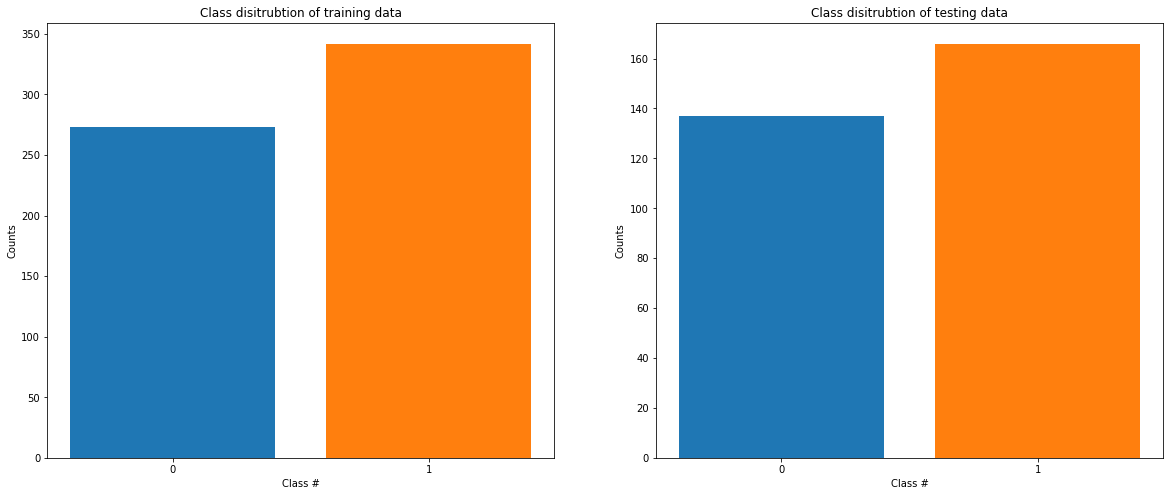

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

# Plot class distribution of training data
labels, counts = np.unique(y_train, return_counts=True)
ax1.bar(labels, counts, align='center', color=plt.cm.get_cmap('tab10').colors)
ax1.set_xticks(labels)
ax1.set_xticklabels([0, 1])
ax1.set_title("Class disitrubtion of training data")
ax1.set_xlabel("Class #")
ax1.set_ylabel("Counts")

# Plot class distribution of testing data
labels, counts = np.unique(y_test, return_counts=True)
ax2.bar(labels, counts, align='center', color=plt.cm.get_cmap('tab10').colors)
ax2.set_xticks(labels)
ax2.set_xticklabels([0, 1])
ax2.set_title("Class disitrubtion of testing data")
ax2.set_xlabel("Class #")
ax2.set_ylabel("Counts")

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39d2aca4c0>,
      dtype=object)

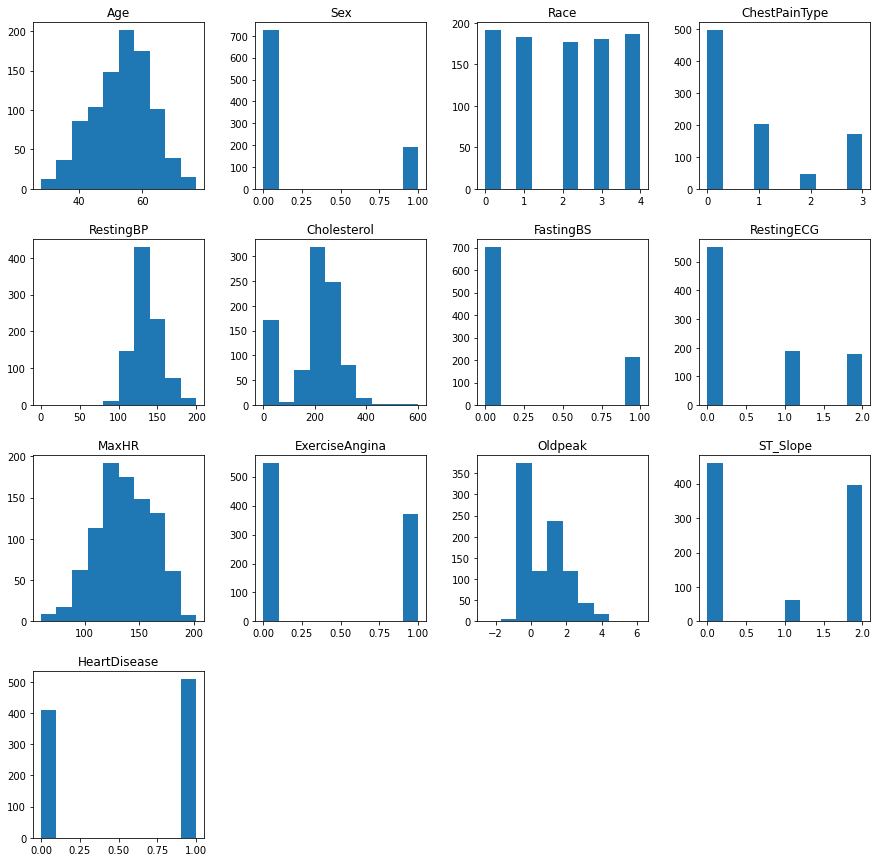

In [53]:
# Histogram for features in complete dataset
df.hist(figsize=(15, 15), grid=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39d32c56d0>,
      dtype=object)

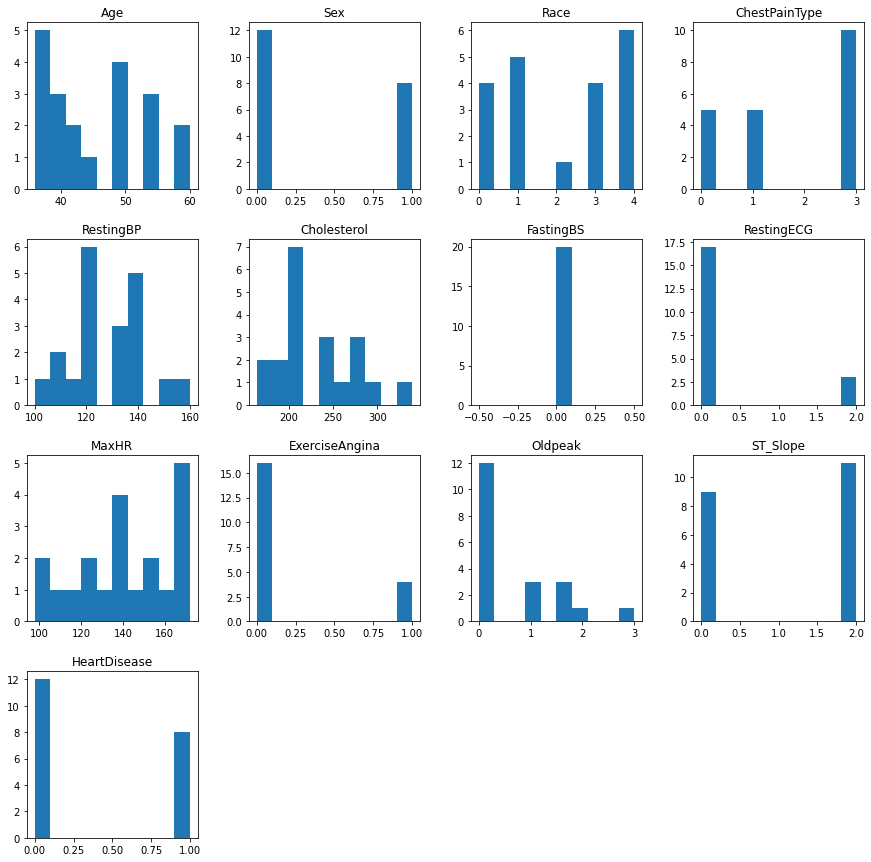

In [54]:
# Histogram for each feature for the first 20 rows of the dataset
df.head(20).hist(figsize=(15, 15), grid=False)

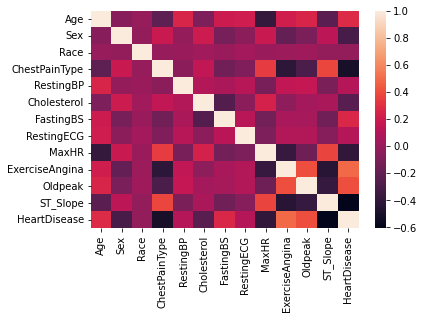

In [23]:
import seaborn as sns

# Create heatmap
sns.heatmap(df.corr())

## 4. [DE][PA] Create a basic classifier for TriageAssist using logistic regression. Use the full dataset (not just the 20 rows in Q3). 

In [24]:
# Use Scikit's logistic regression model as a binary classifier for fitting and predicting the data
model = sk_LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Caluclate accuracy by determining how many of the predicted labels match the testing labels
accuracy = np.sum(y_test == y_pred) / len(y_pred)
print("ACCURACY:\n" + str(accuracy) + "\n")

ACCURACY:
0.7986798679867987



## 5. [DE][PA] In the tutorial, you were introduced to the IBM differential privacy package and created a basic differentially private classifier using this library. Create a differentially private classifier for this dataset using logistic regression. 

In [39]:
# Use IBM's logistic regression model as a binary classifier for fitting and predicting the data
dp_model = dp_LogisticRegression()
dp_model.fit(X_train, y_train)
dp_model.predict(X_test)

# Caluclate accuracy using built-in score() function
accuracy = dp_model.score(X_test, y_test)
print("ACCURACY:\n" + str(accuracy) + "\n")

ACCURACY:
0.5874587458745875



/usr/local/lib/python3.8/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


## 6. [DE][PA] Compare the differential private classifier’s accuracy with the non-private classifier you created in step 4. 

In [45]:
# Compare accuracies of standard and DP classifier (prior to fine-tuning epsilon parameter)
sk_model = sk_LogisticRegression(max_iter=1000)
sk_model.fit(X_train, y_train)
y_pred = sk_model.predict(X_test)
accuracy = np.sum(y_test == y_pred) / len(y_pred)
print("ACCURACY:\n" + str(accuracy) + "\n")

dp_model = dp_LogisticRegression()
dp_model.fit(X_train, y_train)
dp_model.predict(X_test)
dp_accuracy = dp_model.score(X_test, y_test)
print("DP ACCURACY:\n" + str(dp_accuracy) + "\n")

ACCURACY:
0.7986798679867987

DP ACCURACY:
0.43234323432343236



/usr/local/lib/python3.8/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


## 7. [DE][PA] Calculate and illustrate (via a graph) how classification accuracy shifts with respect to different values of epsilon. You can find sample code for this in the tutorial demo on myCourses.

/usr/local/lib/python3.8/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/usr/local/lib/python3.8/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/usr/local/lib/python3.8/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Da

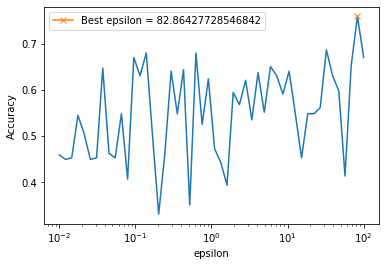


OPTIMAL EPSILON ACCURACY:
0.759075907590759



In [55]:
# Create list of epsilons using logspace()
epsilons = np.logspace(-2, 2, 50)
# Empty list to store caluclated accuracies
accuracy = list()

# Get accuracy for each epsilon
for epsilon in epsilons:
    dp_model = dp_LogisticRegression(epsilon=epsilon)
    dp_model.fit(X_train, y_train)
    
    accuracy.append(dp_model.score(X_test, y_test))

# Plot accuracies and keep track of optimal accuracy and corresponding epsilon
plt.semilogx(epsilons, accuracy)
plt.plot(epsilons[np.argmax(accuracy)], accuracy[np.argmax(accuracy)], marker='x', label="Best epsilon = " + str(epsilons[np.argmax(accuracy)]))
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

# Print optimal epsilon accuracy
print("\nOPTIMAL EPSILON ACCURACY:\n" + str(accuracy[np.argmax(accuracy)]) + "\n")